In [1]:
from math import pi
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd.functional import jacobian
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

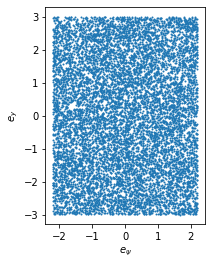

In [2]:
# The first step in learning a neural certificate is to define the dynamics and build a dataset.

# Define the neural network used to model the throttle response
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cuda = torch.device("cpu")

        self.linear1 = torch.nn.Linear(2, 20)
        self.linear2 = torch.nn.Linear(20, 1)

    def forward(self, inputs):
        output = self.linear2(torch.sigmoid(self.linear1(inputs)))
        return output

throttle_nn_file_path = "data/autorally_throttle_model.pth"
throttle_nn = Net()
throttle_nn.load_state_dict(torch.load(throttle_nn_file_path))
throttle_factor = 0.45

def throttle(T, omega_r):
    input_tensor = torch.hstack((T.reshape(-1, 1), omega_r.reshape(-1, 1) / throttle_factor))
    return throttle_nn(input_tensor)

# Let's define the dynamics in closed-loop form for now
n_states = 8
n_controls = 2
def dynamics_fn(x, u, rho = 0.0, dt=0.05):
    """
    Autorally dynamics from https://www.overleaf.com/project/62c749c795f528dca01412b1
    
    args:
        x: state
        u: control
        rho: curvature
    """
    # unpack state and controls
    vx, vy, psi_dot, omega_f, omega_r, e_psi, e_y, s = (
        x[:, 0], x[:, 1], x[:, 2], x[:, 3], x[:, 4], x[:, 5], x[:, 6], x[:, 7]
    )
    delta, T = u[:, 0], u[:, 1]
    T = torch.maximum(T, torch.zeros_like(T))
    
    # Define parameters
    g = 9.81
    m_kg = 21.76
    Iz_kgm2 = 1.12
    Iwf_kgm2 = 0.1
    lf_m = 0.34
    lr_m = 0.23
    rf_m = 0.095
    rr_m = 0.09
    h_m = 0.12
    B = 4.0
    C = 1.0
    D = 1.0
    
    # Avoid divide by zero
    omega_f = torch.maximum(omega_f, torch.ones_like(omega_f))
    omega_r = torch.maximum(omega_r, torch.ones_like(omega_r))
    
    # Compute the wheel velocities
    v_fx = vx * torch.cos(delta) + vy * torch.sin(delta) + psi_dot * lf_m * torch.sin(delta)
    v_fy = vy * torch.cos(delta) - vx * torch.sin(delta) + psi_dot * lf_m * torch.cos(delta)
    v_rx = vx
    v_ry = vy - psi_dot * lr_m
    # Compute magnitude of velocity
    V = torch.sqrt(vx ** 2 + vy ** 2)
    
    # Compute front and rear slip
    sigma_fx = (v_fx - omega_f * rf_m) / (omega_f * rf_m)
    sigma_fy = v_fy / (omega_f * rf_m)
    sigma_rx = (v_rx - omega_r * rr_m) / (omega_r * rr_m)
    sigma_ry = v_ry / (omega_r * rr_m)
    # And get magnitudes
    sigma_f = torch.sqrt(sigma_fx ** 2 + sigma_fy ** 2)
    sigma_r = torch.sqrt(sigma_rx ** 2 + sigma_ry ** 2)
    
    # Compute coefficient of friction at each wheel
    mu_f = D * torch.sin(C * torch.atan(B * sigma_f))
    mu_r = D * torch.sin(C * torch.atan(B * sigma_r))
    # Decompose coefficient of friction into directional components
    mu_fx = - sigma_fx / sigma_f * mu_f
    mu_fy = - sigma_fy / sigma_f * mu_f
    mu_rx = - sigma_rx / sigma_r * mu_r
    mu_ry = - sigma_ry / sigma_r * mu_r
    
    # Compute normal forces at each wheel
    f_fz = (
        (m_kg * g * lr_m - m_kg * g * mu_rx * h_m)
        / (lf_m + lr_m + mu_fx * h_m * torch.cos(delta) - mu_fy * h_m * torch.sin(delta) - mu_rx * h_m)
    )
    f_rz = m_kg * g - f_fz
    
    # Compute longitudinal and lateral friction forces at each wheel
    f_fx = f_fz * mu_fx
    f_fy = f_fz * mu_fy
    f_rx = f_rz * mu_rx
    f_ry = f_rz * mu_ry
    
    # Compute derivatives
    vx_dot = (f_fx * torch.cos(delta) - f_fy * torch.sin(delta) + f_rx) / m_kg + vy * psi_dot
    vy_dot = (f_fx * torch.sin(delta) + f_fy * torch.cos(delta) + f_ry) / m_kg - vx * psi_dot
    psi_ddot = ((f_fy * torch.cos(delta) + f_fx * torch.sin(delta)) * lf_m - f_ry * lr_m) / Iz_kgm2
    omega_f_dot = -rf_m * f_fx / Iwf_kgm2
    omega_r_dot = throttle(T, omega_r).squeeze()
    e_psi_dot = psi_dot - (vx * torch.cos(e_psi) - vy * torch.sin(e_psi)) / (1 - rho * e_y) * rho
    e_y_dot = vx * torch.sin(e_psi) + vy * torch.cos(e_psi)
    s_dot = (vx * torch.cos(e_psi) - vy * torch.sin(e_psi)) / (1 - rho * e_y)
    
    x_next = torch.zeros_like(x)
    x_next[:, 0] = vx + dt * vx_dot
    x_next[:, 1] = vy + dt * vy_dot
    x_next[:, 2] = psi_dot + dt * psi_ddot
    x_next[:, 3] = omega_f + dt * omega_f_dot
    x_next[:, 4] = omega_r + dt * omega_r_dot
    x_next[:, 5] = e_psi + dt * e_psi_dot
    x_next[:, 6] = e_y + dt * e_y_dot
    x_next[:, 7] = s + dt * s_dot
    
    return x_next

# We can build a dataset in the simplest possible way by randomly sampling a bunch of points
n_train = int(1e4)
x_train = torch.Tensor(n_train, n_states).uniform_(-1.0, 1.0)
state_ranges = [20, 20, 2 * pi, 50, 50, 0.7 * pi, 3.0, 10.0]
state_centers = [0, 0, 0, 50, 50, 0, 0, 10]
for i, (state_range, state_center) in enumerate(zip(state_ranges, state_centers)):
    x_train[:, i] *= state_range
    x_train[:, i] += state_center

# Also define a function for selecting the inputs to the neural networks (ignore s)
n_inputs = n_states + 1
state_scale = [20, 20, 2 * pi, 100, 100, 0.7 * pi, 3.0 / 10, 20.0]
def nn_input(x):
    nn_input = torch.zeros(x.shape[0], n_inputs)
    nn_input[:, :-2] = x[:, :-1]  # ignore s
    nn_input[:, -2] = torch.sin(x[:, -3])  # add sin e_psi
    nn_input[:, -1] = torch.cos(x[:, -3])  # add cos e_psi
    
    # scale by state bounds
    scale = torch.ones_like(nn_input)
    scale[:, :-2] = torch.tensor([1 / scale for scale in state_scale[:-1]])
    nn_input = nn_input * scale
    
    return nn_input

# We can plot the dataset to make sure we have good coverage (this is less helpful in higher dimensions)
plt.scatter(x_train[:, -3], x_train[:, -2], s=1.0)
plt.xlabel(r"$e_{\psi}$")
plt.ylabel(r"$e_y$")
plt.gca().set_aspect("equal")

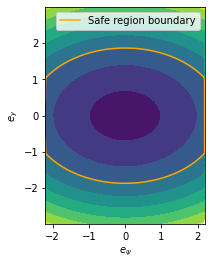

In [3]:
# For a barrier function, we need to define the safe and unsafe regions. In the neural_clbf code we
# did this using a pair of functions that label the safe/unsafe regions. Here, let's try something a bit
# different: a function that gives the "distance" to the safe region. It should be negative inside the
# safe region and positive outside (you could think of it as a "danger index")
track_width = 1.5

def danger_index(x):
    danger = x[:, -2] ** 2 - track_width ** 2  # don't run off the side
    danger += 0.5 * (x[:, -3] ** 2 - (pi/2) ** 2)  # don't turn too far
    return danger

# Let's plot this to make sure we got it right
plt.tricontourf(x_train[:, -3], x_train[:, -2], danger_index(x_train))
plt.xlabel(r"$e_{\psi}$")
plt.ylabel(r"$e_y$")
plt.gca().set_aspect("equal")

# It will be convenient to define a function to plot an overlay of the safe/unsafe regions
def plot_safe_unsafe_boundary(ax):
    ax.plot([], [], "orange", label="Safe region boundary")
    ax.tricontour(x_train[:, -3], x_train[:, -2], danger_index(x_train), levels=[0.0], colors=["orange"])

plot_safe_unsafe_boundary(plt.gca())
plt.legend(loc="upper right");

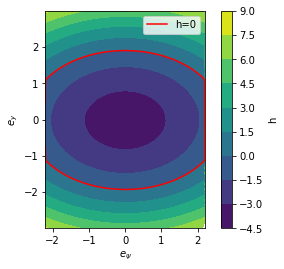

In [4]:
# Now we need to learn both a controller and a barrier function
# You could also learn a CBF and derive the controller using a QP,
# but that involves a bit more plumbing that I'll add later.

# Let's define both of these as neural networks. Unlike the Lyapunov function, which has
# a quadratic prior, we don't have a good prior structure for the barrier function, so
# we'll just use a standard neural net. We will use the danger index as a prior and add
# the neural network as a residual on top of that
class BarrierNN(torch.nn.Module):
    def __init__(
        self,
        hidden_layers: int,
        hidden_layer_width: int,
        n_states: int,
        danger_index_fn,
    ):
        """
        A model for learning a barrier function.
        
        We'll learn the barrier function as the output of a neural network

        args:
            hidden_layers: how many hidden layers to have
            hidden_layer_width: how many neurons per hidden layer
            n_states: how many input state dimensions
            danger_index_fn: a function giving the danger index (should be
                positive in the unsafe region and negative in the safe region)
        """
        super(BarrierNN, self).__init__()
        self.danger_index_fn = danger_index_fn

        # Construct the network
        self.layers = OrderedDict()
        self.layers["input_linear"] = nn.Linear(
            n_states,
            hidden_layer_width,
        )
        for i in range(hidden_layers):
            self.layers[f"layer_{i}_activation"] = nn.Tanh()
            self.layers[f"layer_{i}_linear"] = nn.Linear(
                hidden_layer_width, hidden_layer_width
            )
        self.layers["output_activation"] = nn.Tanh()
        self.layers["output_linear"] = nn.Linear(
            hidden_layer_width, 1
        )
#         self.layers["output_activation_2"] = nn.Tanh()
        self.nn = nn.Sequential(self.layers)

    def forward(self, x: torch.Tensor):
        h = self.nn(nn_input(x))  # batch size x 1
        return self.danger_index_fn(x).squeeze() + h.squeeze()
    
# Make the barrier network.
barrier_nn = BarrierNN(2, 16, n_inputs, danger_index)

# This will be randomly initialized, but we can still plot it!
with torch.no_grad():  # no gradient needed for plotting
    # Instead of projecting all of our data into the xy plane, let's take a slice around
    # the mean point
    x_slice = x_train.clone()
    slice_idx = [0, 1, 2, 3, 4, 7]
    x_slice[:, slice_idx] = x_slice[:, slice_idx].mean()
    plt.tricontourf(x_slice[:, -3], x_slice[:, -2], barrier_nn(x_slice))
    plt.colorbar(label="h")
    plt.plot([], [], c="r", label="h=0")
    plt.tricontour(x_slice[:, -3], x_slice[:, -2], barrier_nn(x_slice), levels=[0.0], colors=["r"])
    plt.xlabel(r"$e_{\psi}$")
    plt.ylabel(r"$e_y$")
    plt.legend()
    plt.gca().set_aspect("equal")

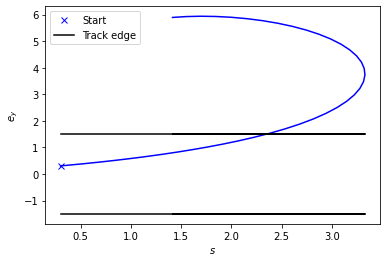

In [5]:
# Now we can define a policy network in a similar way
class ControlNN(torch.nn.Module):
    def __init__(
        self,
        hidden_layers: int,
        hidden_layer_width: int,
        n_states: int,
        n_controls: int,
    ):
        """
        A model for learning a control policy.

        args:
            hidden_layers: how many hidden layers to have
            hidden_layer_width: how many neurons per hidden layer
            n_states: how many input state dimensions
            n_controls: how many output control dimensions
        """
        super(ControlNN, self).__init__()


        # Construct the network
        self.layers = OrderedDict()
        self.layers["input_linear"] = nn.Linear(
            n_states,
            hidden_layer_width,
        )
        self.layers["input_activation"] = nn.Tanh()
        for i in range(hidden_layers):
            self.layers[f"layer_{i}_linear"] = nn.Linear(
                hidden_layer_width, hidden_layer_width
            )
            self.layers[f"layer_{i}_activation"] = nn.Tanh()
        self.layers["output_linear"] = nn.Linear(
            hidden_layer_width, n_controls
        )
        self.layers[f"output_activation"] = nn.Tanh()
        self.nn = nn.Sequential(self.layers)

    def forward(self, x: torch.Tensor):
        u = self.nn(nn_input(x))  # batch size x n_controls
        # The output tanh limits us to [-1, 1]. This is fine for delta, but shift
        # T up to [0, 1]
        shift = torch.zeros_like(u)
        shift[:, 0] = 0.0
        shift[:, 1] = 0.5
        scale = torch.ones_like(u)
        scale[:, 0] = pi / 4.0
        scale[:, 1] = 0.3
        return u * scale + shift

# Make the control network
# Add one dimension to the states for the sine and cosine
control_nn = ControlNN(2, 16, n_inputs, n_controls)

# This will be randomly initialized, and so it will likely not contol the system very well,
# but that won't stop us from trying!
with torch.no_grad():  # no gradient needed for simulation/plotting
    dt = 0.05
    n_steps = 50
    x_sim = torch.zeros((n_steps, n_states))
    x_sim[0, :] = torch.zeros(8) + 0.3
    for tstep in range(1, n_steps):
        x_current = x_sim[tstep - 1, :].reshape(1, n_states)
        u = control_nn(x_current)
        x_sim[tstep, :] = dynamics_fn(x_current, u, dt=dt)

    t = torch.linspace(0, dt * n_steps, n_steps)
    plt.plot(x_sim[0, -1], x_sim[0, -2], "bx", label="Start")
    plt.plot(x_sim[:, -1], x_sim[:, -2], "b")
    plt.plot(x_sim[:, -1], 0 * x_sim[:, -1] + track_width, "k-", label="Track edge")
    plt.plot(x_sim[:, -1], 0 * x_sim[:, -1] - track_width, "k-")
    plt.xlabel(r"$s$")
    plt.ylabel(r"$e_y$")
    plt.legend()

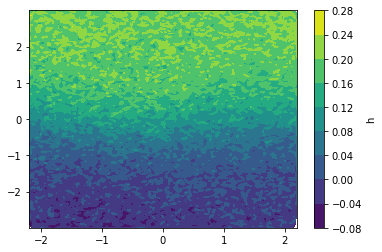

In [6]:
# Let's visualize the policy
with torch.no_grad():
    u = control_nn(x_train)
    plt.tricontourf(x_train[:, -3], x_train[:, -2], u[:, 0])
    plt.colorbar(label="h")

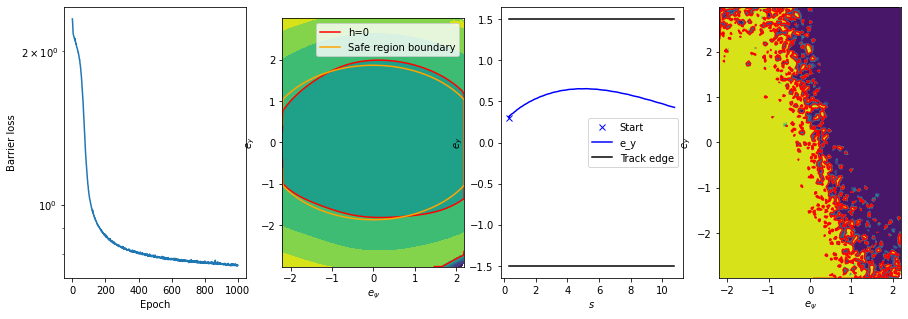

In [7]:
# Not great, but we can do better!

# The next step is to define the loss that let's us refine our barrier function and
# controller to be safe. We need two terms in our loss function here: one will train
# the barrier function to roughly match the safety index, and the other will
# train the barrier function and controller to satisfy the barrier function's
# derivative requirement.

# Let's define a barrier function to be negative in the safe region and positive
# in the unsafe region, then the derivative constraint is h_next <= -alpha * h

def barrier_loss(x):
    loss = torch.tensor(0.0)
    
    # The barrier function should upper bound the danger index (i.e. not
    # classify any unsafe points as safe)
    matching_weight = 1e0
    danger_index = barrier_nn.danger_index_fn(x)
    matching_loss = F.relu((danger_index - barrier_nn(x)) ** 2 - 0.3).mean()
#     matching_loss = F.relu(danger_index - barrier_nn(x)).mean()
    loss += matching_weight * matching_loss
    
    # The barrier function should have "sufficiently negative" derivative
    # Use a numerical approximation of the derivative
    h_now = barrier_nn(x)
    dt = 0.1
    x_next = torch.zeros_like(x) + x
    # It's important to integrate here over multiple substeps so control actions
    # have some time to take effect
    substeps = 5
    for _ in range(substeps):
        u = control_nn(x_next)
        x_next = dynamics_fn(x_next, u, dt=dt / substeps)
    h_next = barrier_nn(x_next)
    
    barrier_alpha = 0.9  # governs the allowable rate of change
    margin = 0.1
    barrier_weight = 1e0
    barrier_loss = F.relu(margin + h_next - barrier_alpha * h_now).mean()
    loss += barrier_weight * barrier_loss

    return loss
    
# Now we can do training!
learning_rate = 1e-4
optimizer = torch.optim.Adam(
    list(barrier_nn.parameters()) + list(control_nn.parameters()),
#     list(control_nn.parameters()),
    lr=learning_rate
)

n_epochs = 1000  # run through the dataset this many times
batch_size = 64  # how many points to evaluate at a time
losses = []
fig, axs = plt.subplots(1, 3)
for epoch in range(n_epochs + 1):
    permutation = torch.randperm(n_train)

    loss_accumulated = 0.0
    epoch_range = range(0, n_train, batch_size)
    for i in epoch_range:
        batch_indices = permutation[i : i + batch_size]
        x_batch = x_train[batch_indices]

        # Forward pass: get the barrier loss
        loss = barrier_loss(x_batch)

        # Compute backpropagate and step the optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate the loss for logging
        loss_accumulated += loss.detach()

    losses.append(loss_accumulated / (n_train / batch_size))
    
    if epoch % 10 == 0:
        with torch.no_grad():
            plt.close(fig)
            fig, axs = plt.subplots(1, 4, figsize=(15, 5))

            axs[0].semilogy(losses)
            axs[0].set_ylabel("Barrier loss")
            axs[0].set_xlabel("Epoch")

            slice_idx = [0, 1, 2, 3, 4, 7]
            x_slice[:, slice_idx] = x_slice[:, slice_idx].mean()
            axs[1].tricontourf(x_slice[:, -3], x_slice[:, -2], barrier_nn(x_slice))
            axs[1].plot([], [], c="r", label="h=0")
            axs[1].tricontour(x_slice[:, -3], x_slice[:, -2], barrier_nn(x_slice), levels=[0.0], colors=["r"])
            axs[1].set_xlabel(r"$e_{\psi}$")
            axs[1].set_ylabel(r"$e_y$")
            plot_safe_unsafe_boundary(axs[1])
            axs[1].legend()
            axs[1].set_aspect("equal")
            
            dt = 0.05
            n_steps = 50
            x_sim = torch.zeros((n_steps, n_states))
            x_sim[0, :] = torch.zeros(8) + 0.3
            for tstep in range(1, n_steps):
                x_current = x_sim[tstep - 1, :].reshape(1, n_states)
                u = control_nn(x_current)
                x_sim[tstep, :] = dynamics_fn(x_current, u)
            
            t = torch.linspace(0, dt * n_steps, n_steps)
            axs[2].plot(x_sim[0, -1], x_sim[0, -2], "bx", label="Start")
            axs[2].plot(x_sim[:, -1], x_sim[:, -2], "b", label="e_y")
            axs[2].set_xlabel(r"$s$")
            axs[2].set_ylabel(r"$e_y$")
            axs[2].plot(x_sim[:, -1], 0 * x_sim[:, -1] + track_width, "k-", label="Track edge")
            axs[2].plot(x_sim[:, -1], 0 * x_sim[:, -1] - track_width, "k-")
            axs[2].legend()
            
            u = control_nn(x_train)
            axs[3].tricontourf(x_train[:, -3], x_train[:, -2], u[:, 0])
            axs[3].tricontour(x_train[:, -3], x_train[:, -2], u[:, 0], levels=[0.0], colors=["r"])
            axs[3].set_xlabel(r"$e_{\psi}$")
            axs[3].set_ylabel(r"$e_y$")

            display.display(fig)
            display.clear_output(wait=True)

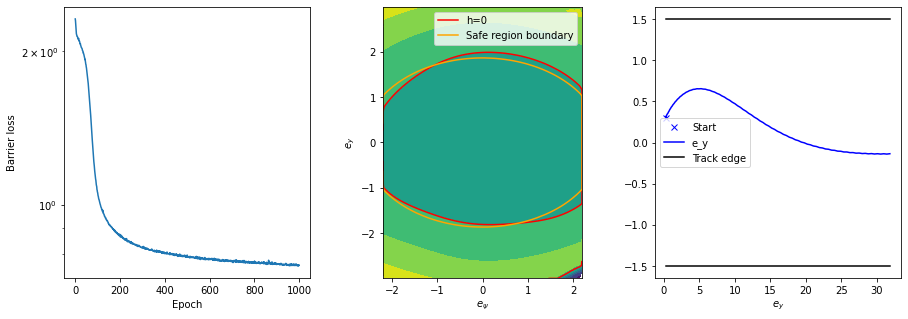

In [11]:
with torch.no_grad():
    plt.close(fig)
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].semilogy(losses)
    axs[0].set_ylabel("Barrier loss")
    axs[0].set_xlabel("Epoch")

    slice_idx = [0, 1, 2, 3, 4, 7]
    x_slice[:, slice_idx] = x_slice[:, slice_idx].mean()
    axs[1].tricontourf(x_slice[:, -3], x_slice[:, -2], barrier_nn(x_slice))
    axs[1].plot([], [], c="r", label="h=0")
    axs[1].tricontour(x_slice[:, -3], x_slice[:, -2], barrier_nn(x_slice), levels=[0.0], colors=["r"])
    axs[1].set_xlabel(r"$e_{\psi}$")
    axs[1].set_ylabel(r"$e_y$")
    plot_safe_unsafe_boundary(axs[1])
    axs[1].legend()
    axs[1].set_aspect("equal")

    dt = 0.05
    n_steps = 100
    x_sim = torch.zeros((n_steps, n_states))
    x_sim[0, :] = torch.zeros(8) + 0.3
    for tstep in range(1, n_steps):
        x_current = x_sim[tstep - 1, :].reshape(1, n_states)
        u = control_nn(x_current)
        x_sim[tstep, :] = dynamics_fn(x_current, u, rho=0, dt=dt)

    t = torch.linspace(0, dt * n_steps, n_steps)
    axs[2].plot(x_sim[0, -1], x_sim[0, -2], "bx", label="Start")
    axs[2].plot(x_sim[:, -1], x_sim[:, -2], "b", label="e_y")
    axs[2].set_xlabel(r"$s$")
    axs[2].set_xlabel(r"$e_y$")
    axs[2].plot(x_sim[:, -1], 0 * x_sim[:, -1] + track_width, "k-", label="Track edge")
    axs[2].plot(x_sim[:, -1], 0 * x_sim[:, -1] - track_width, "k-")
    axs[2].legend()

#     display.display(fig)
#     display.clear_output(wait=True)

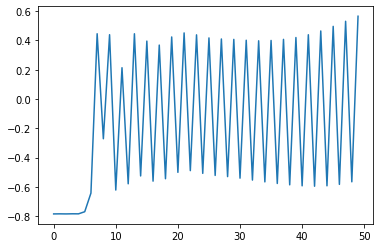

In [12]:
with torch.no_grad():
    plt.plot(control_nn(x_sim)[:50, 0])

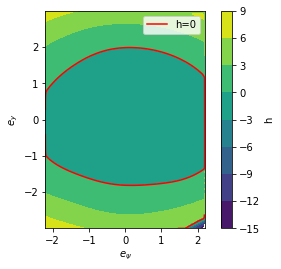

In [13]:
with torch.no_grad():  # no gradient needed for plotting
    # Instead of projecting all of our data into the xy plane, let's take a slice around
    # the mean point
    x_slice = x_train.clone()
    slice_idx = [0, 1, 2, 3, 4, 7]
    x_slice[:, slice_idx] = x_slice[:, slice_idx].mean()
    plt.tricontourf(x_slice[:, -3], x_slice[:, -2], barrier_nn(x_slice))
    plt.colorbar(label="h")
    plt.plot([], [], c="r", label="h=0")
    plt.tricontour(x_slice[:, -3], x_slice[:, -2], barrier_nn(x_slice), levels=[0.0], colors=["r"])
    plt.xlabel(r"$e_{\psi}$")
    plt.ylabel(r"$e_y$")
    plt.legend()
    plt.gca().set_aspect("equal")

In [15]:
# Save the control and barrier networks
torch.save({"model": barrier_nn.state_dict(), "alpha": 0.9}, "data/autorally_barrier_net.pth")
torch.save(control_nn.state_dict(), "data/autorally_control_net.pth")